# Comparing models for a planar triple-junction solar cell structure

This example calculates absorption per layer, reflection, and transmision for a triple-junction solar cell with
the following structure:

- double-layer anti-reflection coating made of 120 nm MgF2 and 74 nm Ta2O5
- 464 nm InGaP (50% InP, 50% GaP): the top junction of the solar cell, bandgap 1.9 eV
- 1682 nm GaAs: the middle junction of the solar cell, bandgap 1.42 eV
- 300 um Ge: the bottom junction/growth substrate, bandgap 0.67 eV
- 100 nm SiN
- silver back mirror

The R/A/T values are calculated in 4 different ways:

- Using the matrix method, and calculating the redistribution matrices using TMM
- Using the matrix method, and calculating the redistribution matrices using integated ray-tracing + TMM
- Using the matrix method, and calculating the redistribution matrices using RCWA
- Not using the matrix method, and defining the whole structure as a single TMM simulation. The thick Ge layer
  is treated incoherently.

Clearly, using ray-tracing or RCWA to calculate absorption in a completely planar structure is not the best simulation
strategy, but this example serves to illustrate that for such a simple test case where all methods are physically valid,
they all give identical results (minus some noise in the RT/TMM case due to the stochastic nature of these simulations).

In [1]:
import numpy as np

# solcore imports
from solcore.structure import Layer
from solcore import material

# rayflare imports
from rayflare.textures import planar_surface
from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import process_structure, calculate_RAT
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.options import default_options

# plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

pal = sns.color_palette('husl', 5)

cols = cycler('color', pal)

params  = {'axes.prop_cycle': cols}

plt.rcParams.update(params)

First we set up some parameters; wavelengths, thickness of the Ge layer (in m), and options for
the calcultions. We provide a project name to store/load the matrices which are generated and saved,
specify the number of rays to trace in the RT calculation (can be increased to reduce noise) and
set the number of theta bins in the matrix formalism to just 3 since we are calculating a planar
structure at normal incidence, so no light should be scattered into off-normal bins anyway. Then we
set up the materials we need for the calculation, and define the front surface (ARC, GaInP and GaAs)
and the back surface (just SiN).

In [2]:
# Thickness of bottom Ge layer
bulkthick = 300e-6

wavelengths = np.linspace(300, 1850, 200)*1e-9

# set options
options = default_options()
options.wavelengths = wavelengths
options.project_name = 'method_comparison'
options.n_rays = 250
options.n_theta_bins = 3
options.lookuptable_angles = 100
options.parallel = True
options.c_azimuth = 0.001

# set up Solcore materials
Ge = material('Ge')()
GaAs = material('GaAs')()
GaInP = material('GaInP')(In=0.5)
Ag = material('Ag')()
SiN = material('Si3N4')()
Air = material('Air')()
Ta2O5 = material('TaOx1')() # Ta2O5 (SOPRA database)
MgF2 = material('MgF2')() # MgF2 (SOPRA database)


front_materials = [Layer(120e-9, MgF2), Layer(74e-9, Ta2O5), Layer(464e-9, GaInP),
                   Layer(1682e-9, GaAs)]
back_materials = [Layer(100E-9, SiN)]

# make figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(9,7))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
plt.close()

Now we start doing the matrix calculations: the front surface is an Interface to be treated with the
TMM method to generate the redistribution matrices. We give this a name (again for saving/loading the
redistribution matrices) and the layers on the front and back surfaces should be treated coherently
so we set coherent to True. We then make the structure, consisting of the front surface, bulk Ge, and back surface,
and specify the incidence medium (Air) and transmission medium (silver). process_structure checks if
the relevant redistribution matrices already exist and calculates them if not. calculate_RAT performs
the matrix multiplication to calculate the R/A/T values. We then plot the results.

In [3]:
front_surf = Interface('TMM', layers=front_materials, name = 'GaInP_GaAs_TMM',
                       coherent=True)
back_surf = Interface('TMM', layers=back_materials, name = 'SiN_Ag_TMM',
                      coherent=True)


bulk_Ge = BulkLayer(bulkthick, Ge, name = 'Ge_bulk') # bulk thickness in m

SC = Structure([front_surf, bulk_Ge, back_surf], incidence=Air, transmission=Ag)

process_structure(SC, options)

results_TMM_Matrix = calculate_RAT(SC, options)

results_per_pass = results_TMM_Matrix[1]

# only select absorbing layers, sum over passes
results_per_layer_front = np.sum(results_per_pass['a'][0], 0)
ax1.plot(options['wavelengths']*1e9, results_TMM_Matrix[0].R[0], label='R')
ax1.plot(options['wavelengths']*1e9, results_per_layer_front[:,2], label='InGaP')
ax1.plot(options['wavelengths']*1e9, results_per_layer_front[:,3], label='GaAs')
ax1.plot(options['wavelengths']*1e9, results_TMM_Matrix[0].A_bulk[0], label='Ge')
ax1.plot(options['wavelengths']*1e9, results_TMM_Matrix[0].T[0], label='T')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Reflection / Absorption')
ax1.set_title('a) TMM + matrix formalism', loc = 'left')


Making matrix for planar surface using TMM for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
Making matrix for planar surface using TMM for element 2 in structure
Existing angular redistribution matrices found
After iteration 1 : maximum power fraction remaining = 0.13206884072464
After iteration 2 : maximum power fraction remaining = 0.022152753235758545
After iteration 3 : maximum power fraction remaining = 0.003715823302694084


Text(0.0, 1.0, 'a) TMM + matrix formalism')

Same as above, except we are now using the RT_TMM method instead of just TMM. We have to define
a surface texture for the ray-tracer, which in this case is just a flat surface (planar_surface is
a built-in function to generate the triangulated surface required for ray-tracing for the case of a flat surface).

In [4]:
## RT with TMM lookup tables

surf = planar_surface() # [texture, flipped texture]

front_surf = Interface('RT_TMM', layers=front_materials, texture=surf, name = 'GaInP_GaAs_RT',
                       coherent=True)
back_surf = Interface('RT_TMM', layers=back_materials, texture = surf, name = 'SiN_Ag_RT_50k',
                      coherent=True)

SC = Structure([front_surf, bulk_Ge, back_surf], incidence=Air, transmission=Ag)

process_structure(SC, options)

results_RT = calculate_RAT(SC, options)

results_per_pass = results_RT[1]

# only select absorbing layers, sum over passes
results_per_layer_front = np.sum(results_per_pass['a'][0], 0)

ax2.plot(options['wavelengths']*1e9, results_RT[0].R[0], label='R')
ax2.plot(options['wavelengths']*1e9, results_per_layer_front[:,2], label='InGaP')
ax2.plot(options['wavelengths']*1e9, results_per_layer_front[:,3], label='GaAs')
ax2.plot(options['wavelengths']*1e9, results_RT[0].A_bulk[0], label='Ge')
ax2.plot(options['wavelengths']*1e9, results_RT[0].T[0], label='T')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflection / Absorption')
ax2.set_title('b) Ray-tracing/TMM + matrix formalism', loc = 'left')
plt.close()

Making lookuptable for element 0 in structure
Existing lookup table found
Making lookuptable for element 2 in structure
Existing lookup table found
Ray tracing with TMM lookup table for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
Ray tracing with TMM lookup table for element 2 in structure
Existing angular redistribution matrices found
After iteration 1 : maximum power fraction remaining = 0.136188
After iteration 2 : maximum power fraction remaining = 0.0237784248
After iteration 3 : maximum power fraction remaining = 0.00415171297008


Then we use the matrix formalism with RCWA. In this case, we have to specify the number of Fourier orders to use,
set to 2 here because there will be no diffraction so we can use the minimum number of orders to speed
up the calculation, and the lattice vectors. Because there is no grating in this case the d_vectors
can be set to anything.

In [5]:
## RCWA

front_surf = Interface('RCWA', layers=front_materials, name = 'GaInP_GaAs_RCWA',
                       coherent=True, d_vectors = ((500,0), (0,500)), rcwa_orders=2)
back_surf = Interface('RCWA', layers=back_materials, name = 'SiN_Ag_RCWA',
                      coherent=True, d_vectors = ((500,0), (0,500)), rcwa_orders=2)


SC = Structure([front_surf, bulk_Ge, back_surf], incidence=Air, transmission=Ag)

process_structure(SC, options)

results_RCWA_Matrix = calculate_RAT(SC, options)

results_per_pass = results_RCWA_Matrix[1]
R_per_pass = np.sum(results_per_pass['r'][0], 2)

# only select absorbing layers, sum over passes
results_per_layer_front = np.sum(results_per_pass['a'][0], 0)


ax3.plot(options['wavelengths']*1e9, results_RCWA_Matrix[0].R[0], label='R')
ax3.plot(options['wavelengths']*1e9, results_per_layer_front[:,2], label='InGaP')
ax3.plot(options['wavelengths']*1e9, results_per_layer_front[:,3], label='GaAs')
ax3.plot(options['wavelengths']*1e9, results_RCWA_Matrix[0].A_bulk[0], label='Ge')
ax3.plot(options['wavelengths']*1e9, results_RCWA_Matrix[0].T[0], label='T')
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Reflection / Absorption')
ax3.set_title('c) RCWA + matrix formalism', loc = 'left')
plt.close()

RCWA calculation for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
RCWA calculation for element 2 in structure
Existing angular redistribution matrices found
After iteration 1 : maximum power fraction remaining = 0.13206884072463942
After iteration 2 : maximum power fraction remaining = 0.02215275323575838
After iteration 3 : maximum power fraction remaining = 0.0037158233026940435


Finally, we use RayFlare's tmm_structure class to calculate the same quantities using just TMM.
To be consistent with the matrix method, which treats the bulk layer (Ge) incoherently, we have to
specify that the full structure is not coherent and provide a coherency list (the ARC, InGaP and GaAs
are coherent, the Ge is incoherent, and finally the SiN is to be treated coherently).

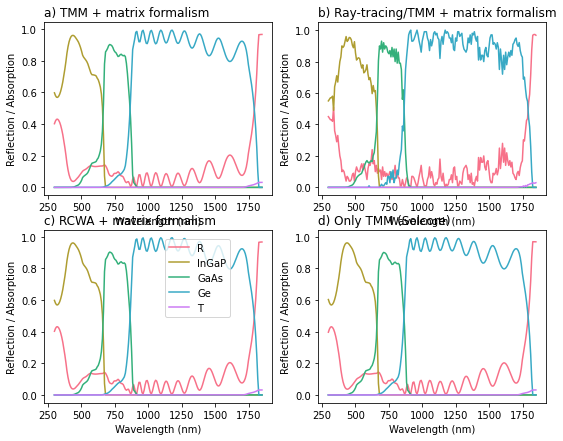

In [6]:
## pure TMM
all_layers = front_materials + [Layer(bulkthick, Ge)] + back_materials

coh_list = len(front_materials)*['c'] + ['i'] + ['c']

options.coherency_list = coh_list
options.coherent = False

TMM_setup = tmm_structure(all_layers, incidence=Air, transmission=Ag, no_back_reflection=False)

TMM_res = TMM_setup.calculate(options)

ax4.plot(options['wavelengths']*1e9, TMM_res['R'], label='R')

ax4.plot(options['wavelengths']*1e9, TMM_res['A_per_layer'][:,2], label='InGaP')
ax4.plot(options['wavelengths']*1e9, TMM_res['A_per_layer'][:,3], label='GaAs')
ax4.plot(options['wavelengths']*1e9, TMM_res['A_per_layer'][:,4], label='Ge')
ax4.plot(options['wavelengths']*1e9, TMM_res['T'], label='T')
ax4.set_xlabel('Wavelength (nm)')
ax4.set_ylabel('Reflection / Absorption')
ax4.set_title('d) Only TMM (Solcore)', loc = 'left')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0, 0, 0.42, 0.46), loc='upper right')

fig

Plotting all the results together, you can see that they all give the same results (with the expection
of noise in the RT/TMM case).